# walmart sales Prediction

In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import opendatasets as od
import os
from zipfile import ZipFile

import plotly.express as px

%matplotlib inline

In [3]:
od.download('https://www.kaggle.com/c/walmart-recruiting-store-sales-forecasting/data')

Skipping, found downloaded files in "./walmart-recruiting-store-sales-forecasting" (use force=True to force download)


In [4]:
with ZipFile('./walmart-recruiting-store-sales-forecasting/train.csv.zip') as f:
    f.extractall(path='walmart-recruiting-store-sales-forecasting')

with ZipFile('./walmart-recruiting-store-sales-forecasting/test.csv.zip') as f:
    f.extractall(path='walmart-recruiting-store-sales-forecasting')

with ZipFile('./walmart-recruiting-store-sales-forecasting/features.csv.zip') as f:
    f.extractall(path='walmart-recruiting-store-sales-forecasting')

with ZipFile('./walmart-recruiting-store-sales-forecasting/sampleSubmission.csv.zip') as f:
    f.extractall(path='walmart-recruiting-store-sales-forecasting')

## Data download

In [5]:
import os
from sklearn.pipeline import Pipeline
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np
import plotly.express as px
from zipfile import ZipFile
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
!pip3 install xgboost
import xgboost


from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score

pd.set_option("display.max_columns", 120)
pd.set_option("display.max_rows", 120)




plt.style.use('seaborn-poster')
plt.style.use("fivethirtyeight")
plt.rcParams['font.family'] = 'serif'

matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (12, 8)
matplotlib.rcParams['figure.facecolor'] = '#00000000'


[notice] A new release of pip available: 22.2.2 -> 23.3.1
[notice] To update, run: pip3 install --upgrade pip


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import opendatasets as od
import os
from zipfile import ZipFile

import plotly.express as px

%matplotlib inline

In [7]:
od.download('https://www.kaggle.com/c/walmart-recruiting-store-sales-forecasting/data')

Skipping, found downloaded files in "./walmart-recruiting-store-sales-forecasting" (use force=True to force download)


In [8]:
os.listdir('walmart-recruiting-store-sales-forecasting')

['features.csv.zip',
 'sampleSubmission.csv',
 'test.csv',
 'sampleSubmission.csv.zip',
 'train.csv',
 'features.csv',
 'test.csv.zip',
 'train.csv.zip',
 'stores.csv']

In [9]:
import pyspark

In [10]:
from pyspark.sql import SparkSession

In [11]:
from pyspark.sql import SparkSession

# Create a SparkSession
spark = SparkSession.builder.appName("WalmartSalesForecast").getOrCreate()

# Read the CSV files and create Spark DataFrames
train_df = spark.read.csv('./walmart-recruiting-store-sales-forecasting/train.csv', header=True, inferSchema=True)
store_df = spark.read.csv('./walmart-recruiting-store-sales-forecasting/stores.csv', header=True, inferSchema=True)
feature_df = spark.read.csv('./walmart-recruiting-store-sales-forecasting/features.csv', header=True, inferSchema=True)
test_df = spark.read.csv('./walmart-recruiting-store-sales-forecasting/test.csv', header=True, inferSchema=True)

23/11/07 16:52:05 WARN Utils: Your hostname, Surajs-MacBook-Air.local resolves to a loopback address: 127.0.0.1; using 10.0.0.189 instead (on interface en0)
23/11/07 16:52:05 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/11/07 16:52:06 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [12]:
train_df.printSchema()

root
 |-- Store: integer (nullable = true)
 |-- Dept: integer (nullable = true)
 |-- Date: date (nullable = true)
 |-- Weekly_Sales: double (nullable = true)
 |-- IsHoliday: boolean (nullable = true)



In [13]:
store_df.printSchema()

root
 |-- Store: integer (nullable = true)
 |-- Type: string (nullable = true)
 |-- Size: integer (nullable = true)



In [14]:
feature_df.printSchema()

root
 |-- Store: integer (nullable = true)
 |-- Date: date (nullable = true)
 |-- Temperature: double (nullable = true)
 |-- Fuel_Price: double (nullable = true)
 |-- MarkDown1: string (nullable = true)
 |-- MarkDown2: string (nullable = true)
 |-- MarkDown3: string (nullable = true)
 |-- MarkDown4: string (nullable = true)
 |-- MarkDown5: string (nullable = true)
 |-- CPI: string (nullable = true)
 |-- Unemployment: string (nullable = true)
 |-- IsHoliday: boolean (nullable = true)



In [15]:
test_df.printSchema()

root
 |-- Store: integer (nullable = true)
 |-- Dept: integer (nullable = true)
 |-- Date: date (nullable = true)
 |-- IsHoliday: boolean (nullable = true)



In [16]:
feature_df.describe().show()


23/11/07 16:52:13 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+---------------+-----------------+-------------------+-----------------+-----------------+------------------+-----------------+------------------+------------------+-----------------+
|summary|          Store|      Temperature|         Fuel_Price|        MarkDown1|        MarkDown2|         MarkDown3|        MarkDown4|         MarkDown5|               CPI|     Unemployment|
+-------+---------------+-----------------+-------------------+-----------------+-----------------+------------------+-----------------+------------------+------------------+-----------------+
|  count|           8190|             8190|               8190|             8190|             8190|              8190|             8190|              8190|              8190|             8190|
|   mean|           23.0|59.35619780219781| 3.4059918192918217|7032.371785714266|3384.176593632328|1760.1001799058915|3292.935886258671| 4132.216422222234|172.46080918276078|7.826821038790305|
| stddev|12.987966099514| 18.678606

In [17]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum as spark_sum

# Assuming you have already created the SparkSession as 'spark'
# and you have a DataFrame named 'feature_df'

# Count the null values in each column
null_counts = feature_df.select(*[
    spark_sum(col(column_name).isNull().cast("int")).alias(column_name)
    for column_name in feature_df.columns
])

# Show the result
null_counts.show()


+-----+----+-----------+----------+---------+---------+---------+---------+---------+---+------------+---------+
|Store|Date|Temperature|Fuel_Price|MarkDown1|MarkDown2|MarkDown3|MarkDown4|MarkDown5|CPI|Unemployment|IsHoliday|
+-----+----+-----------+----------+---------+---------+---------+---------+---------+---+------------+---------+
|    0|   0|          0|         0|        0|        0|        0|        0|        0|  0|           0|        0|
+-----+----+-----------+----------+---------+---------+---------+---------+---------+---+------------+---------+



In [18]:
columns_to_drop = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']

# Drop the specified columns
feature_df = feature_df.drop(*columns_to_drop)
feature_df.show(5)

+-----+----------+-----------+----------+-----------+------------+---------+
|Store|      Date|Temperature|Fuel_Price|        CPI|Unemployment|IsHoliday|
+-----+----------+-----------+----------+-----------+------------+---------+
|    1|2010-02-05|      42.31|     2.572|211.0963582|       8.106|    false|
|    1|2010-02-12|      38.51|     2.548|211.2421698|       8.106|     true|
|    1|2010-02-19|      39.93|     2.514|211.2891429|       8.106|    false|
|    1|2010-02-26|      46.63|     2.561|211.3196429|       8.106|    false|
|    1|2010-03-05|       46.5|     2.625|211.3501429|       8.106|    false|
+-----+----------+-----------+----------+-----------+------------+---------+
only showing top 5 rows



In [19]:
num_rows = feature_df.count()

# Get the number of columns in the DataFrame
num_columns = len(feature_df.columns)

print(f"Number of rows: {num_rows}")
print(f"Number of columns: {num_columns}")

Number of rows: 8190
Number of columns: 7


combine data set

In [20]:
train = train_df.join(store_df, on='Store', how='left').join(feature_df, on=['Store', 'Date', 'IsHoliday'], how='left')
test = test_df.join(store_df, on='Store', how='left').join(feature_df, on=['Store', 'Date', 'IsHoliday'], how='left')

# Show the first few rows of the merged DataFrames (optional)
train.show(5)
test.show(5)

+-----+----------+---------+----+------------+----+------+-----------+----------+-----------+------------+
|Store|      Date|IsHoliday|Dept|Weekly_Sales|Type|  Size|Temperature|Fuel_Price|        CPI|Unemployment|
+-----+----------+---------+----+------------+----+------+-----------+----------+-----------+------------+
|    1|2010-02-05|    false|   1|     24924.5|   A|151315|      42.31|     2.572|211.0963582|       8.106|
|    1|2010-02-12|     true|   1|    46039.49|   A|151315|      38.51|     2.548|211.2421698|       8.106|
|    1|2010-02-19|    false|   1|    41595.55|   A|151315|      39.93|     2.514|211.2891429|       8.106|
|    1|2010-02-26|    false|   1|    19403.54|   A|151315|      46.63|     2.561|211.3196429|       8.106|
|    1|2010-03-05|    false|   1|     21827.9|   A|151315|       46.5|     2.625|211.3501429|       8.106|
+-----+----------+---------+----+------------+----+------+-----------+----------+-----------+------------+
only showing top 5 rows

+-----+-----

# EDA and preproccessing

In [21]:
# Collect the data locally as a Pandas DataFrame
train_local = train.toPandas()

# Calculate the count of each store type
types = train_local['Type'].value_counts(dropna=False)

# Create the pie chart using Plotly
fig = px.pie(types, names=types.index, values=types, title="Types of store")

# Show the plot
fig.show()

CodeCache: size=131072Kb used=33611Kb max_used=33676Kb free=97460Kb
 bounds [0x000000010a1e0000, 0x000000010c2f0000, 0x00000001121e0000]
 total_blobs=12241 nmethods=11293 adapters=860
 compilation: disabled (not enough contiguous free space left)


Java HotSpot(TM) 64-Bit Server VM warning: CodeCache is full. Compiler has been disabled.
Java HotSpot(TM) 64-Bit Server VM warning: Try increasing the code cache size using -XX:ReservedCodeCacheSize=


**Most of the store are of A type**

In [22]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import count, col, lit
import plotly.subplots as sp
import plotly.graph_objs as go

# Initialize a Spark session
spark = SparkSession.builder.appName("WalmartSalesForecast").getOrCreate()

# Assuming 'train' and 'test' are PySpark DataFrames
cat_cols = ['IsHoliday', 'Type']

fig = sp.make_subplots(rows=2, cols=1, subplot_titles=cat_cols)

for i, col in enumerate(cat_cols):
    train_cat_col = train.groupBy(col).agg(count("*").alias("count"))
    train_count = train.count()
    train_cat_col = train_cat_col.withColumn("percentage", train_cat_col["count"] / lit(train_count))

    test_cat_col = test.groupBy(col).agg(count("*").alias("count"))
    test_count = test.count()
    test_cat_col = test_cat_col.withColumn("percentage", test_cat_col["count"] / lit(test_count))

    # Convert the PySpark DataFrame to a Pandas DataFrame for plotting
    train_cat_pandas = train_cat_col.toPandas()
    test_cat_pandas = test_cat_col.toPandas()

    fig.add_trace(
        go.Bar(x=train_cat_pandas[col], y=train_cat_pandas["percentage"], name='train ' + col, legendgroup=i),
        row=i + 1, col=1)

    fig.add_trace(
        go.Bar(x=test_cat_pandas[col], y=test_cat_pandas["percentage"], name='test ' + col, legendgroup=i),
        row=i + 1, col=1)

fig.update_layout(height=800, width=1000, title_text="plots of categorical data from train and test", legend_tracegroupgap=340)

# Show the plot
fig.show()


In [23]:
#from pyspark.sql import SparkSession
#import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Assuming you have already created the SparkSession as 'spark'
# and you have the DataFrames 'train' and 'test'

# Collect the data locally as Pandas DataFrames
train_local = train.toPandas()
test_local = test.toPandas()

cat_cols = ['IsHoliday', 'Type']

fig = make_subplots(rows=2, cols=1, subplot_titles=cat_cols)

for i, col in enumerate(cat_cols):
    train_cat_col = train_local[col].value_counts(normalize=True).to_frame()
    test_cat_col = test_local[col].value_counts(normalize=True).to_frame()

    fig.add_trace(
        go.Bar(x=train_cat_col.index, y=train_cat_col[col], name='train ' + ' ' + col, legendgroup=i),
        row=i + 1, col=1,
    )

    fig.add_trace(
        go.Bar(x=test_cat_col.index, y=test_cat_col[col], name='test ' + ' ' + col, legendgroup=i),
        row=i + 1, col=1,
    )

fig.update_layout(
    height=800,
    width=1000,
    title_text="Plots of categorical data from train and test",
    legend_tracegroupgap=340,
)

fig.show()


**insights**
* for categorical Data distribution remain same for train and test Data

In [24]:
train.describe().show()

+-------+------------------+------------------+------------------+------+------------------+------------------+------------------+------------------+------------------+
|summary|             Store|              Dept|      Weekly_Sales|  Type|              Size|       Temperature|        Fuel_Price|               CPI|      Unemployment|
+-------+------------------+------------------+------------------+------+------------------+------------------+------------------+------------------+------------------+
|  count|            421570|            421570|            421570|421570|            421570|            421570|            421570|            421570|            421570|
|   mean|22.200545579619043| 44.26031738501317|15981.258123467413|  NULL|136727.91573878596| 60.09005873283215|3.3610265270300355|171.20194682295747| 7.960288694641632|
| stddev|12.785297389902782|30.492054015786017| 22711.18351916329|  NULL| 60980.58332810143|18.447931147616114|0.4585145371277487|39.159275623012874|1.8632

In [25]:
test.describe().show()

+-------+------------------+------------------+------+------------------+------------------+-------------------+------------------+------------------+
|summary|             Store|              Dept|  Type|              Size|       Temperature|         Fuel_Price|               CPI|      Unemployment|
+-------+------------------+------------------+------+------------------+------------------+-------------------+------------------+------------------+
|  count|            115064|            115064|115064|            115064|            115064|             115064|            115064|            115064|
|   mean|  22.2382065633039| 44.33952409094069|  NULL|136497.68892094833| 53.94180386567838| 3.5815463220471546|176.96134664861165| 6.868733166888243|
| stddev|12.809929591378935|30.656410130030174|  NULL|61106.926438169576|18.724152888948137|0.23944193035707104| 41.23996660333092|1.5834273529056506|
|    min|                 1|                 1|     A|             34875|             -7.29|  

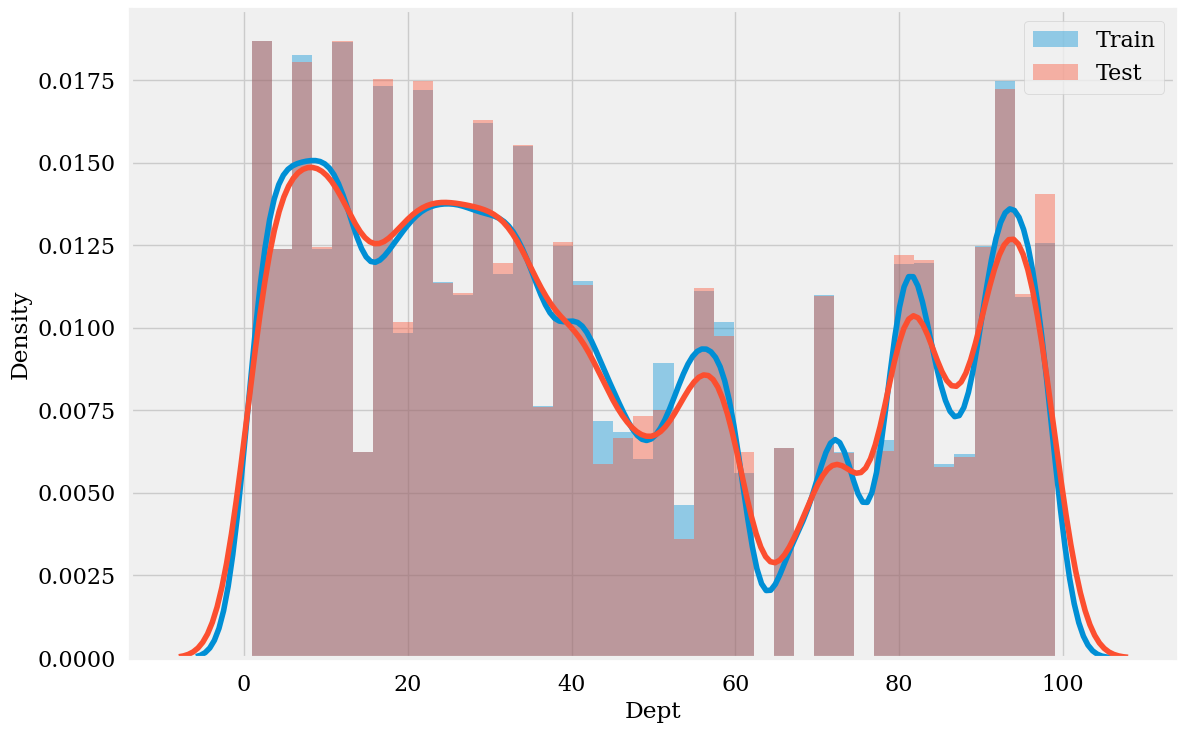

In [26]:
# Collect the 'Dept' column data locally as Pandas Series
train_dept = train.select('Dept').toPandas()['Dept']
test_dept = test.select('Dept').toPandas()['Dept']

# Create distribution plots using seaborn
sns.distplot(train_dept, kde=True, bins=40, label='Train')
sns.distplot(test_dept, kde=True, bins=40, label='Test')

# Display the plot
plt.legend()
plt.show()

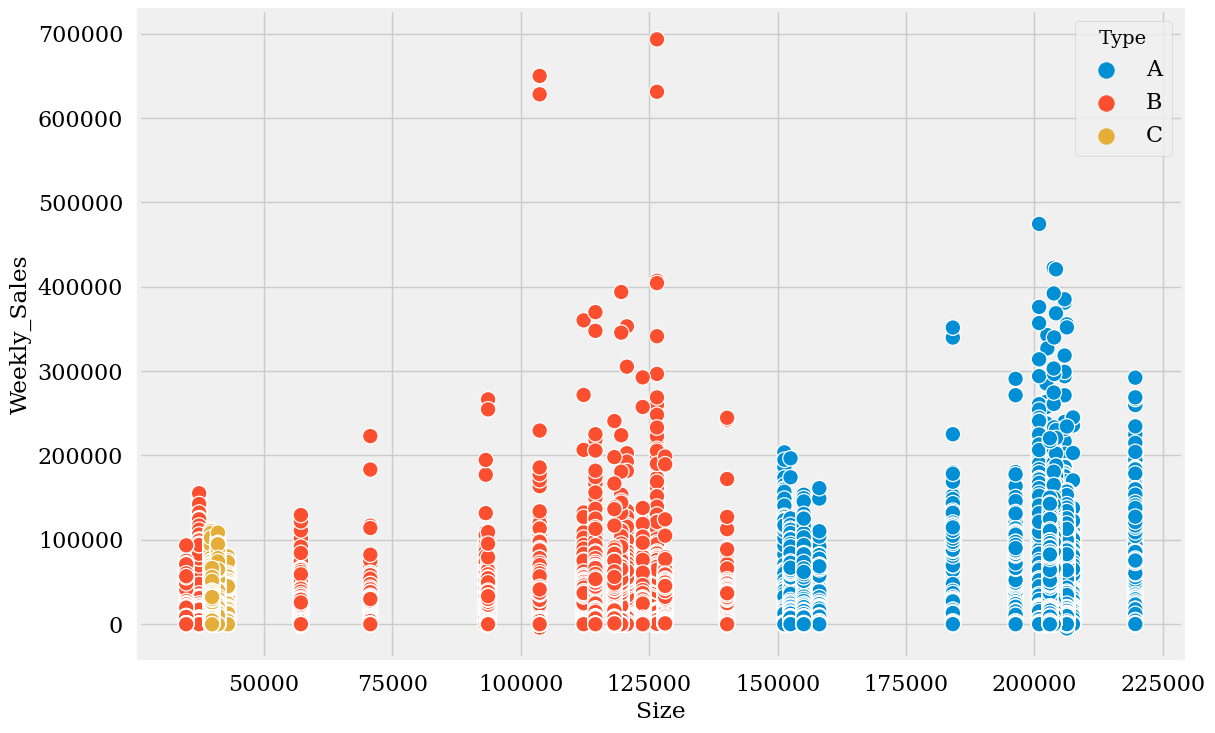

In [27]:
# Collect the 'Size' and 'Weekly_Sales' columns data locally as Pandas DataFrame
train_pd = train.select('Size', 'Weekly_Sales', 'Type').toPandas()

# Create scatter plot using seaborn
sns.scatterplot(data=train_pd, x='Size', y='Weekly_Sales', hue='Type')

# Display the plot
plt.show()

In [28]:
train.show(5)

+-----+----------+---------+----+------------+----+------+-----------+----------+-----------+------------+
|Store|      Date|IsHoliday|Dept|Weekly_Sales|Type|  Size|Temperature|Fuel_Price|        CPI|Unemployment|
+-----+----------+---------+----+------------+----+------+-----------+----------+-----------+------------+
|    1|2010-02-05|    false|   1|     24924.5|   A|151315|      42.31|     2.572|211.0963582|       8.106|
|    1|2010-02-12|     true|   1|    46039.49|   A|151315|      38.51|     2.548|211.2421698|       8.106|
|    1|2010-02-19|    false|   1|    41595.55|   A|151315|      39.93|     2.514|211.2891429|       8.106|
|    1|2010-02-26|    false|   1|    19403.54|   A|151315|      46.63|     2.561|211.3196429|       8.106|
|    1|2010-03-05|    false|   1|     21827.9|   A|151315|       46.5|     2.625|211.3501429|       8.106|
+-----+----------+---------+----+------------+----+------+-----------+----------+-----------+------------+
only showing top 5 rows



**insights**
* As the size of store increases sales also increases
* we can see three clusters means `Size` of store depend upon  `Type` of store

In [29]:
# Calculate the average weekly sales for each store type using PySpark
avg_sales = train.groupBy('Type').avg('Weekly_Sales').withColumnRenamed('avg(Weekly_Sales)', 'Average_Weekly_Sales')

# Collect the PySpark DataFrame data locally as a Pandas DataFrame
avg_sales_pd = avg_sales.toPandas()

# Create a bar chart using Plotly Express
fig = px.bar(avg_sales_pd, x='Type', y='Average_Weekly_Sales', title="Average Weekly Sales by Store Type")

# Show the plot
fig.show()

**insights**
* A Type store done most of the sales

In [30]:
train_columns = train.columns

# Print the column names
print(train_columns)

['Store', 'Date', 'IsHoliday', 'Dept', 'Weekly_Sales', 'Type', 'Size', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']


# columns  preproccessing

* Make a funtion to extract weeks months years from date column so that we can make pipeline easily

## **step 1 of pipeline**

In [31]:
# Convert the PySpark DataFrame to a Pandas DataFrame
train_pd = train.toPandas()
test_pd = test.toPandas()

# Use pd.to_datetime() to convert the 'Date' column to datetime format in Pandas DataFrame
train_pd['Date'] = pd.to_datetime(train_pd['Date'])
test_pd['Date'] = pd.to_datetime(test_pd['Date'])

# Convert the Pandas DataFrame back to PySpark DataFrame
train = spark.createDataFrame(train_pd)
test = spark.createDataFrame(test_pd)

In [32]:
break_date1 = pd.Timestamp("2011-06-05")
break_date2 = pd.Timestamp("2012-06-05")


train_df1 = train[train["Date"] <= break_date1]
test_df1 = train[(train["Date"] > break_date1) & (train["Date"] <= break_date2)]
val_df = train[train["Date"] > break_date2]

In [33]:
## step 1

from pyspark.sql import functions as F

def extract_week(df):
    df = df.withColumn("week", F.weekofyear(df["Date"]))
    df = df.withColumn("month", F.month(df["Date"]))
    df = df.withColumn("year", F.year(df["Date"]))
    return df

In [34]:
#Date="Date"
train = extract_week(train)
tarin_df1=extract_week(train_df1)
test_df1=extract_week(test_df1)
val_df=extract_week(val_df)

In [35]:
train_df1.show(5)

23/11/07 16:53:25 WARN TaskSetManager: Stage 100 contains a task of very large size (3683 KiB). The maximum recommended task size is 1000 KiB.


+-----+-------------------+---------+----+------------+----+------+-----------+----------+-----------+------------+
|Store|               Date|IsHoliday|Dept|Weekly_Sales|Type|  Size|Temperature|Fuel_Price|        CPI|Unemployment|
+-----+-------------------+---------+----+------------+----+------+-----------+----------+-----------+------------+
|    1|2010-02-05 00:00:00|    false|   1|     24924.5|   A|151315|      42.31|     2.572|211.0963582|       8.106|
|    1|2010-02-12 00:00:00|     true|   1|    46039.49|   A|151315|      38.51|     2.548|211.2421698|       8.106|
|    1|2010-02-19 00:00:00|    false|   1|    41595.55|   A|151315|      39.93|     2.514|211.2891429|       8.106|
|    1|2010-02-26 00:00:00|    false|   1|    19403.54|   A|151315|      46.63|     2.561|211.3196429|       8.106|
|    1|2010-03-05 00:00:00|    false|   1|     21827.9|   A|151315|       46.5|     2.625|211.3501429|       8.106|
+-----+-------------------+---------+----+------------+----+------+-----

23/11/07 16:53:30 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 100 (TID 122): Attempting to kill Python Worker


23/11/07 16:53:30 WARN TaskSetManager: Stage 101 contains a task of very large size (3683 KiB). The maximum recommended task size is 1000 KiB.


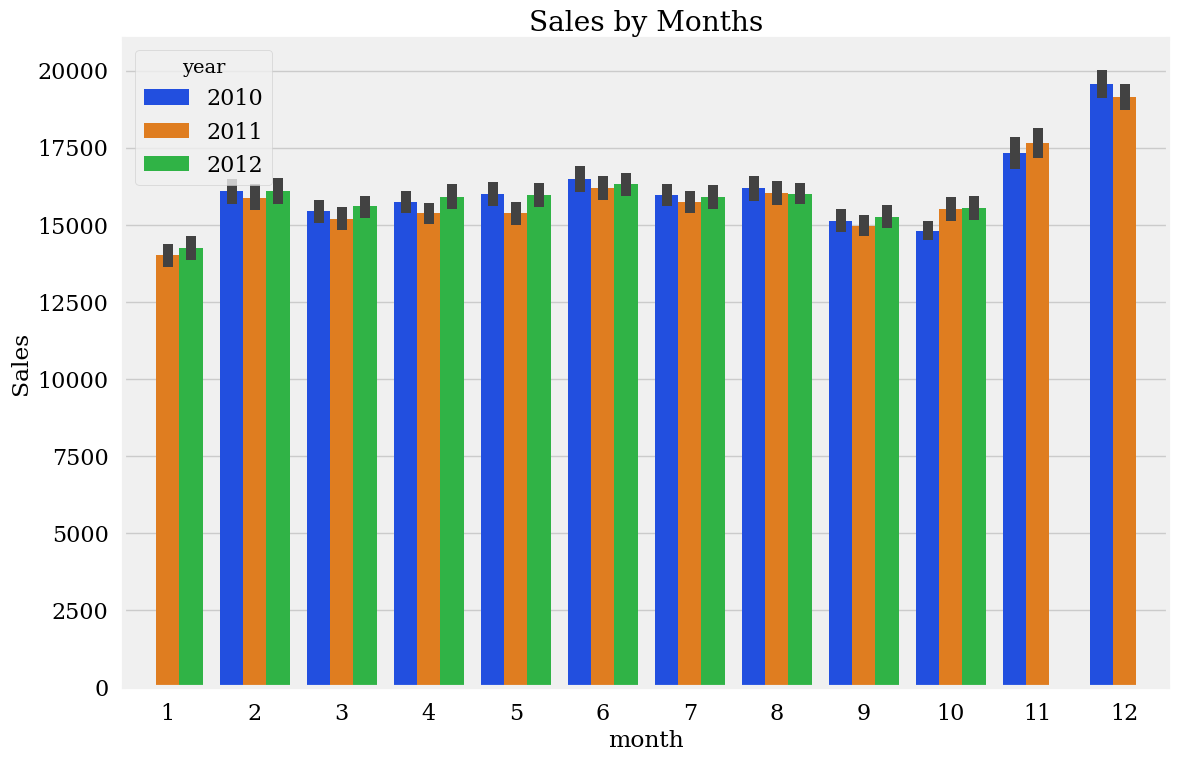

In [36]:
# # Convert the 'Date' column to datetime format in the 'train' DataFrame
# train = train.withColumn('Date', col('Date').cast('date'))

# # Extract the month and year from the 'Date' column
# train = train.withColumn('month', month('Date'))
# train = train.withColumn('year', year('Date'))

# # Convert the PySpark DataFrame to a Pandas DataFrame
# train_pd = train.toPandas()

# # Create a bar plot using seaborn
# sns.barplot(data=train_pd, x='month', y='Weekly_Sales', hue='year', palette="dark")
# plt.title('Sales by Months')
# plt.ylabel('Sales')
# plt.show()
# sns.barplot(data=train,x='month',y='Weekly_Sales',hue='year',palette='bright').set_title('sales by Months')
# plt.ylabel('Sales')
# Assuming you already have the necessary imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Convert the PySpark DataFrame to a Pandas DataFrame
train_pd = train.toPandas()

# Create a bar plot using seaborn
sns.barplot(data=train_pd, x='month', y='Weekly_Sales', hue='year', palette='bright')
plt.title('Sales by Months')
plt.ylabel('Sales')
plt.show()


**insights**
* only slight variation in sales with respect year
* In 2011 sales are relatively lower than both 2010 and 2012
* In first month sales are least and in 12th month sales are higher .May be due to festivals

In [37]:
train.columns

['Store',
 'Date',
 'IsHoliday',
 'Dept',
 'Weekly_Sales',
 'Type',
 'Size',
 'Temperature',
 'Fuel_Price',
 'CPI',
 'Unemployment',
 'week',
 'month',
 'year']

23/11/07 16:53:44 WARN TaskSetManager: Stage 102 contains a task of very large size (3683 KiB). The maximum recommended task size is 1000 KiB.


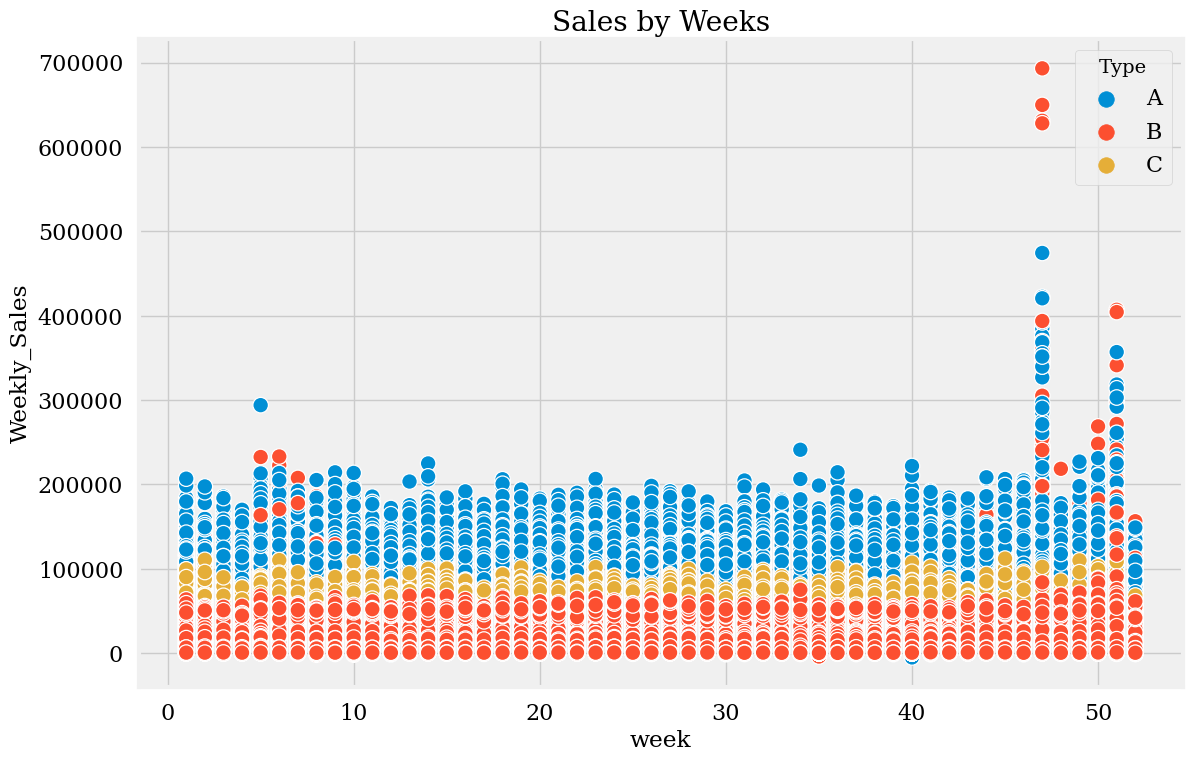

In [38]:
# Assuming you have already imported the necessary libraries
from pyspark.sql.functions import col, weekofyear
import seaborn as sns
import matplotlib.pyplot as plt

# Convert the 'Date' column to datetime format in the 'train' DataFrame
train = train.withColumn('Date', col('Date').cast('date'))

# Extract the week number from the 'Date' column
train = train.withColumn('week', weekofyear('Date'))

# Collect the required columns from the DataFrame locally as a Pandas DataFrame
train_pd = train.select('Weekly_Sales', 'week', 'Type').toPandas()

# Create a scatter plot using seaborn
sns.scatterplot(data=train_pd, y='Weekly_Sales', x='week', hue='Type')

# Set the title
plt.title('Sales by Weeks')

# Show the plot
plt.show()


23/11/07 16:53:55 WARN TaskSetManager: Stage 103 contains a task of very large size (3683 KiB). The maximum recommended task size is 1000 KiB.


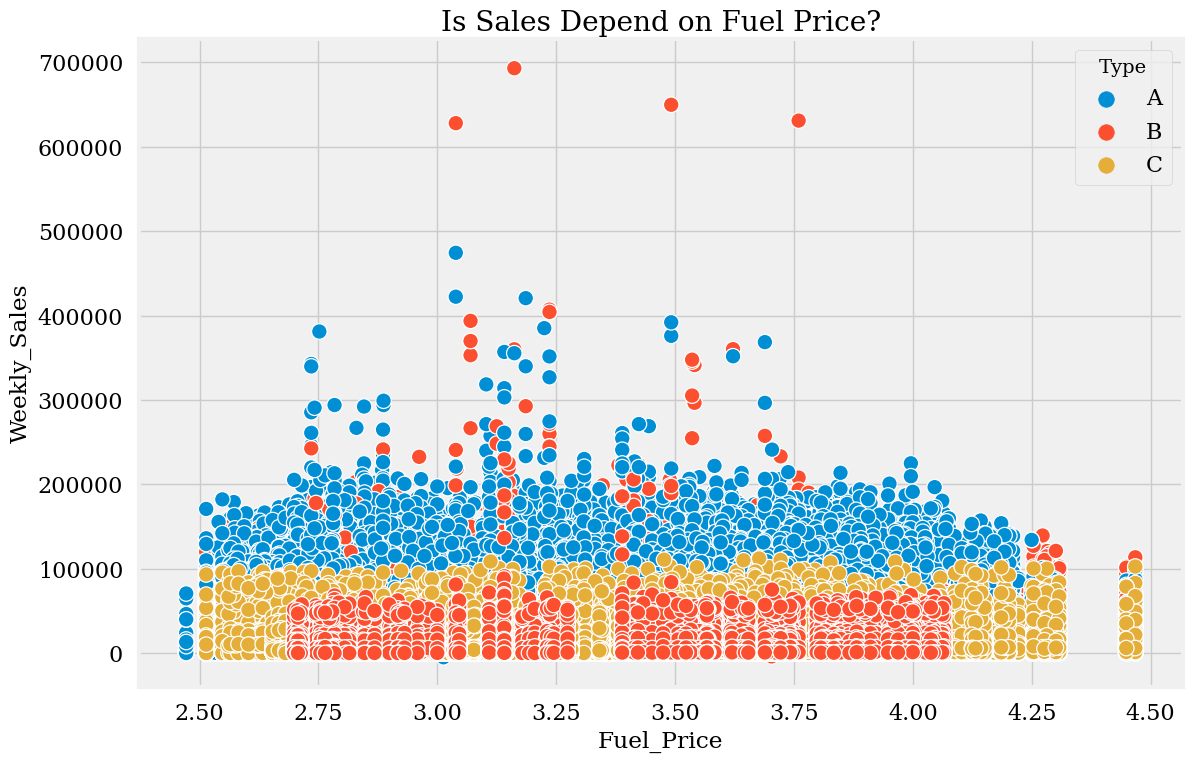

In [39]:
# Convert the 'Date' column to datetime format in the 'train' DataFrame
train = train.withColumn('Date', col('Date').cast('date'))

# Collect the required columns from the DataFrame locally as Pandas DataFrame
train_pd = train.select('Weekly_Sales', 'Fuel_Price', 'Type').toPandas()

# Create scatter plot using seaborn
sns.scatterplot(data=train_pd, y='Weekly_Sales', x='Fuel_Price', hue='Type')

# Set the title
plt.title('Is Sales Depend on Fuel Price?')

# Show the plot
plt.show()

**insights**
* sales does not depend on fuel price

23/11/07 16:54:05 WARN TaskSetManager: Stage 104 contains a task of very large size (3683 KiB). The maximum recommended task size is 1000 KiB.


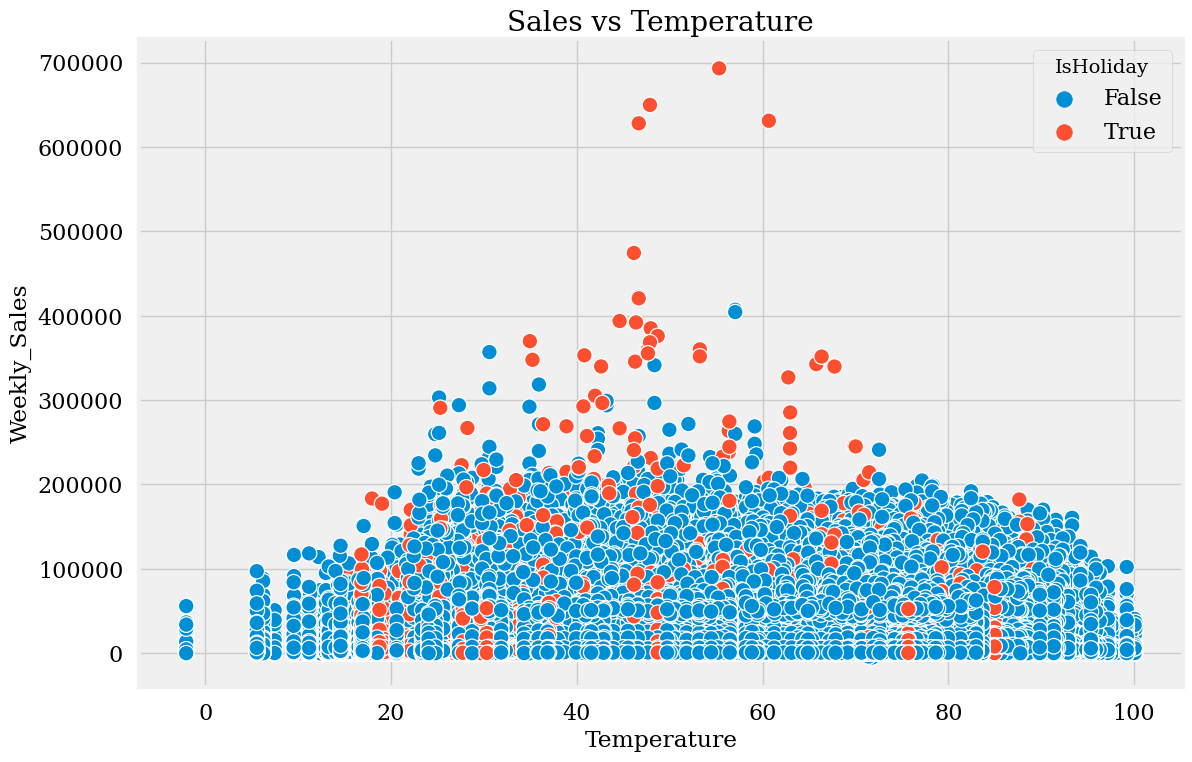

In [40]:
# Convert the 'Date' column to datetime format in the 'train' DataFrame
train = train.withColumn('Date', col('Date').cast('date'))

# Collect the required columns from the DataFrame locally as Pandas DataFrame
train_pd = train.select('Weekly_Sales', 'Temperature', 'IsHoliday').toPandas()

# Create scatter plot using seaborn
sns.scatterplot(data=train_pd, y='Weekly_Sales', x='Temperature', hue='IsHoliday')

# Set the title
plt.title('Sales vs Temperature')

# Show the plot
plt.show()

**insights**
* sales does not depend on Temp only at too high and too low conditions sales are less

23/11/07 16:54:15 WARN TaskSetManager: Stage 105 contains a task of very large size (3683 KiB). The maximum recommended task size is 1000 KiB.


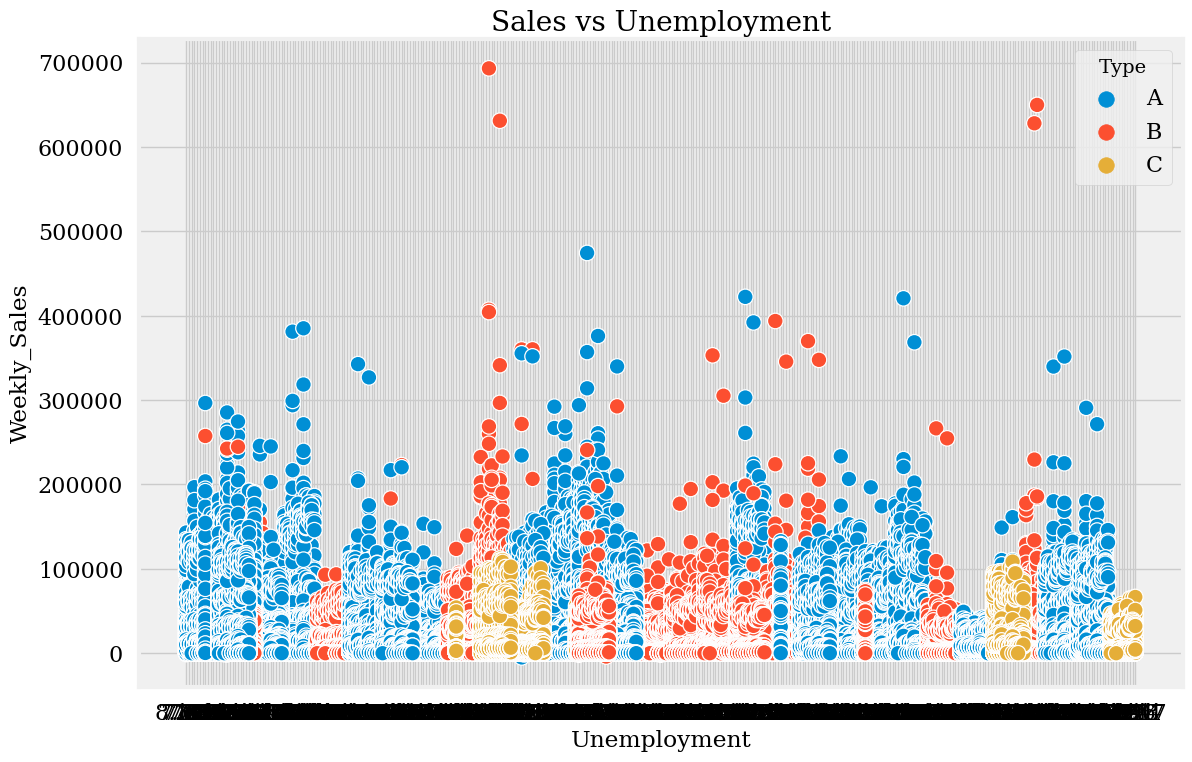

In [41]:
# Convert the 'Date' column to datetime format in the 'train' DataFrame
train = train.withColumn('Date', col('Date').cast('date'))

# Collect the required columns from the DataFrame locally as Pandas DataFrame
train_pd = train.select('Weekly_Sales', 'Unemployment', 'Type').toPandas()

# Create scatter plot using seaborn
sns.scatterplot(data=train_pd, y='Weekly_Sales', x='Unemployment', hue='Type')

# Set the title
plt.title('Sales vs Unemployment')

# Show the plot
plt.show()

**insights**
* Only slightly change in sales as the unemployment increases

23/11/07 16:54:26 WARN TaskSetManager: Stage 106 contains a task of very large size (3683 KiB). The maximum recommended task size is 1000 KiB.


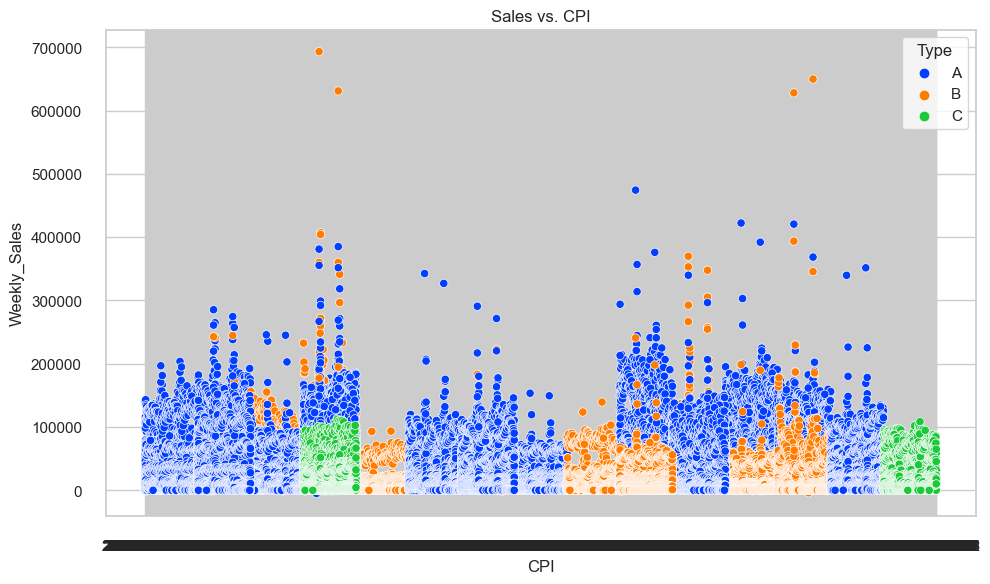

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'train' is a PySpark DataFrame
# Convert PySpark DataFrame to Pandas DataFrame for plotting
train_pd = train.toPandas()

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

scatterplot = sns.scatterplot(data=train_pd, y='Weekly_Sales', x='CPI', hue='Type', palette='bright')
scatterplot.set_title('Sales vs. CPI')

plt.show()


**insights**
* CPI does not affect sales

23/11/07 16:54:48 WARN TaskSetManager: Stage 107 contains a task of very large size (3683 KiB). The maximum recommended task size is 1000 KiB.


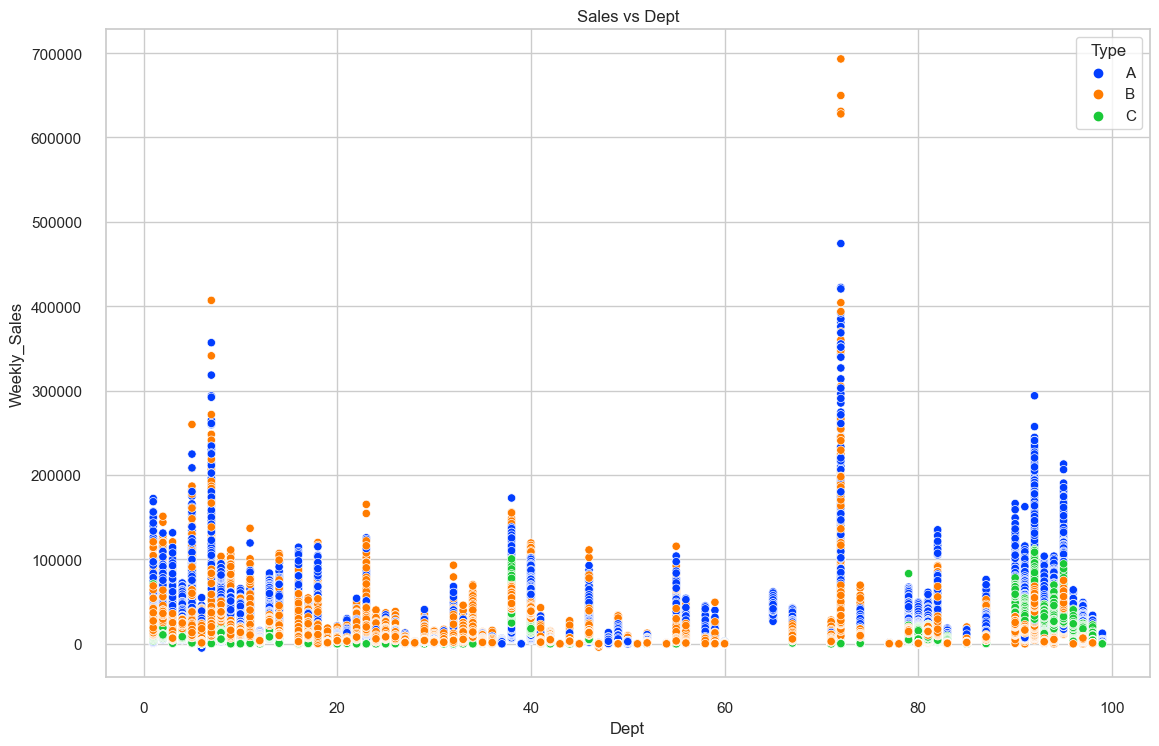

In [43]:
# Convert the 'Date' column to datetime format in the 'train' DataFrame
train = train.withColumn('Date', col('Date').cast('date'))

# Collect the required columns from the DataFrame locally as Pandas DataFrame
train_pd = train.select('Weekly_Sales', 'Dept', 'Type').toPandas()

# Create scatter plot using seaborn
sns.scatterplot(data=train_pd, y='Weekly_Sales', x='Dept', hue='Type', palette='bright')

# Set the title
plt.title('Sales vs Dept')

# Show the plot
plt.show()

**insights**
* Dept does  affect sales
* Different department have different sales

In [44]:
train.show(5)

+-----+----------+---------+----+------------+----+------+-----------+----------+-----------+------------+----+-----+----+
|Store|      Date|IsHoliday|Dept|Weekly_Sales|Type|  Size|Temperature|Fuel_Price|        CPI|Unemployment|week|month|year|
+-----+----------+---------+----+------------+----+------+-----------+----------+-----------+------------+----+-----+----+
|    1|2010-02-05|    false|   1|     24924.5|   A|151315|      42.31|     2.572|211.0963582|       8.106|   5|    2|2010|
|    1|2010-02-12|     true|   1|    46039.49|   A|151315|      38.51|     2.548|211.2421698|       8.106|   6|    2|2010|
|    1|2010-02-19|    false|   1|    41595.55|   A|151315|      39.93|     2.514|211.2891429|       8.106|   7|    2|2010|
|    1|2010-02-26|    false|   1|    19403.54|   A|151315|      46.63|     2.561|211.3196429|       8.106|   8|    2|2010|
|    1|2010-03-05|    false|   1|     21827.9|   A|151315|       46.5|     2.625|211.3501429|       8.106|   9|    3|2010|
+-----+---------

23/11/07 16:54:57 WARN TaskSetManager: Stage 108 contains a task of very large size (3683 KiB). The maximum recommended task size is 1000 KiB.


In [45]:
test.show(5)

+-----+-------------------+---------+----+----+------+-----------+----------+-----------+------------+
|Store|               Date|IsHoliday|Dept|Type|  Size|Temperature|Fuel_Price|        CPI|Unemployment|
+-----+-------------------+---------+----+----+------+-----------+----------+-----------+------------+
|    1|2012-11-02 00:00:00|    false|   1|   A|151315|      55.32|     3.386|223.4627793|       6.573|
|    1|2012-11-09 00:00:00|    false|   1|   A|151315|      61.24|     3.314|223.4813073|       6.573|
|    1|2012-11-16 00:00:00|    false|   1|   A|151315|      52.92|     3.252|223.5129105|       6.573|
|    1|2012-11-23 00:00:00|     true|   1|   A|151315|      56.23|     3.211|223.5619474|       6.573|
|    1|2012-11-30 00:00:00|    false|   1|   A|151315|      52.34|     3.207|223.6109842|       6.573|
+-----+-------------------+---------+----+----+------+-----------+----------+-----------+------------+
only showing top 5 rows



## **pipe line step 2**

In [46]:
from pyspark.sql.functions import col, when

In [47]:
def maping_type(df):
    # map Type column
    df = df.withColumn('Type', when(col('Type') == 'A', '1')
                              .when(col('Type') == 'B', '2')
                              .when(col('Type') == 'C', '3')
                              .otherwise(col('Type')))
    return df

# Call the function and update the DataFrame
#df = maping_type(df)

In [48]:
maping_type(train)
maping_type(train_df1)
maping_type(val_df)
maping_type(test_df1)

DataFrame[Store: bigint, Date: timestamp, IsHoliday: boolean, Dept: bigint, Weekly_Sales: double, Type: string, Size: bigint, Temperature: double, Fuel_Price: double, CPI: string, Unemployment: string, week: int, month: int, year: int]

In [49]:
train.show(5)

+-----+----------+---------+----+------------+----+------+-----------+----------+-----------+------------+----+-----+----+
|Store|      Date|IsHoliday|Dept|Weekly_Sales|Type|  Size|Temperature|Fuel_Price|        CPI|Unemployment|week|month|year|
+-----+----------+---------+----+------------+----+------+-----------+----------+-----------+------------+----+-----+----+
|    1|2010-02-05|    false|   1|     24924.5|   A|151315|      42.31|     2.572|211.0963582|       8.106|   5|    2|2010|
|    1|2010-02-12|     true|   1|    46039.49|   A|151315|      38.51|     2.548|211.2421698|       8.106|   6|    2|2010|
|    1|2010-02-19|    false|   1|    41595.55|   A|151315|      39.93|     2.514|211.2891429|       8.106|   7|    2|2010|
|    1|2010-02-26|    false|   1|    19403.54|   A|151315|      46.63|     2.561|211.3196429|       8.106|   8|    2|2010|
|    1|2010-03-05|    false|   1|     21827.9|   A|151315|       46.5|     2.625|211.3501429|       8.106|   9|    3|2010|
+-----+---------

23/11/07 16:54:57 WARN TaskSetManager: Stage 110 contains a task of very large size (3683 KiB). The maximum recommended task size is 1000 KiB.


## **pipeline step 3**

In [50]:
def convert_to_int(df):
    # Convert 'Type' column to integer
    df = df.withColumn('Type', when(col('Type') == 'A', 1)
                                   .when(col('Type') == 'B', 2)
                                   .when(col('Type') == 'C', 3)
                                   .otherwise(0))

    # Convert 'IsHoliday' column to integer
    df = df.withColumn('IsHoliday', col('IsHoliday').cast('int'))

    return df


In [51]:
# #convert_to_int(train)
# #convert_to_int(train_df1)
# #convert_to_int(test_df1)
# #convert_to_int(val_df)

# def convert_to_int(df):
#     # Convert 'Type' column to integer
#     df = df.withColumn('Type', col('Type').cast('int'))

#     # Convert 'IsHoliday' column to integer
#     df = df.withColumn('IsHoliday', col('IsHoliday').cast('int'))

#     return df

# Call the function and update each DataFrame
train = convert_to_int(train)
train_df1 = convert_to_int(train_df1)
test_df1 = convert_to_int(test_df1)
val_df = convert_to_int(val_df)

In [52]:
train.show(5)

#stop

+-----+----------+---------+----+------------+----+------+-----------+----------+-----------+------------+----+-----+----+
|Store|      Date|IsHoliday|Dept|Weekly_Sales|Type|  Size|Temperature|Fuel_Price|        CPI|Unemployment|week|month|year|
+-----+----------+---------+----+------------+----+------+-----------+----------+-----------+------------+----+-----+----+
|    1|2010-02-05|        0|   1|     24924.5|   1|151315|      42.31|     2.572|211.0963582|       8.106|   5|    2|2010|
|    1|2010-02-12|        1|   1|    46039.49|   1|151315|      38.51|     2.548|211.2421698|       8.106|   6|    2|2010|
|    1|2010-02-19|        0|   1|    41595.55|   1|151315|      39.93|     2.514|211.2891429|       8.106|   7|    2|2010|
|    1|2010-02-26|        0|   1|    19403.54|   1|151315|      46.63|     2.561|211.3196429|       8.106|   8|    2|2010|
|    1|2010-03-05|        0|   1|     21827.9|   1|151315|       46.5|     2.625|211.3501429|       8.106|   9|    3|2010|
+-----+---------

23/11/07 16:54:57 WARN TaskSetManager: Stage 111 contains a task of very large size (3683 KiB). The maximum recommended task size is 1000 KiB.


# Training model


In [53]:
# Select the important columns and target column
input_col = ['Store', 'IsHoliday', 'Type', 'Size', 'week', 'Dept', 'year']
target = ['Weekly_Sales']

# Select the important columns and target column from the DataFrame
selected_train = train.select(input_col + target)

In [61]:
train_df2.show(5)

23/11/08 11:05:03 WARN TaskSetManager: Stage 164 contains a task of very large size (3683 KiB). The maximum recommended task size is 1000 KiB.


+-----+----------+---------+----+------------+----+------+-----------+----------+-----------+------------+----+-----+----+--------------------+
|Store|      Date|IsHoliday|Dept|Weekly_Sales|Type|  Size|Temperature|Fuel_Price|        CPI|Unemployment|week|month|year|            features|
+-----+----------+---------+----+------------+----+------+-----------+----------+-----------+------------+----+-----+----+--------------------+
|    1|2010-02-05|        0|   1|     24924.5|   1|151315|      42.31|     2.572|211.0963582|       8.106|   5|    2|2010|[1.0,0.0,1.0,1513...|
|    1|2010-02-12|        1|   1|    46039.49|   1|151315|      38.51|     2.548|211.2421698|       8.106|   6|    2|2010|[1.0,1.0,1.0,1513...|
|    1|2010-02-19|        0|   1|    41595.55|   1|151315|      39.93|     2.514|211.2891429|       8.106|   7|    2|2010|[1.0,0.0,1.0,1513...|
|    1|2010-02-26|        0|   1|    19403.54|   1|151315|      46.63|     2.561|211.3196429|       8.106|   8|    2|2010|[1.0,0.0,1.0,1

23/11/08 11:05:07 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 164 (TID 505): Attempting to kill Python Worker


23/11/08 11:11:09 WARN TransportChannelHandler: Exception in connection from /10.0.0.189:64694
java.io.IOException: Operation timed out
	at sun.nio.ch.FileDispatcherImpl.read0(Native Method)
	at sun.nio.ch.SocketDispatcher.read(SocketDispatcher.java:39)
	at sun.nio.ch.IOUtil.readIntoNativeBuffer(IOUtil.java:223)
	at sun.nio.ch.IOUtil.read(IOUtil.java:192)
	at sun.nio.ch.SocketChannelImpl.read(SocketChannelImpl.java:378)
	at io.netty.buffer.PooledByteBuf.setBytes(PooledByteBuf.java:254)
	at io.netty.buffer.AbstractByteBuf.writeBytes(AbstractByteBuf.java:1132)
	at io.netty.channel.socket.nio.NioSocketChannel.doReadBytes(NioSocketChannel.java:357)
	at io.netty.channel.nio.AbstractNioByteChannel$NioByteUnsafe.read(AbstractNioByteChannel.java:151)
	at io.netty.channel.nio.NioEventLoop.processSelectedKey(NioEventLoop.java:788)
	at io.netty.channel.nio.NioEventLoop.processSelectedKeysOptimized(NioEventLoop.java:724)
	at io.netty.channel.nio.NioEventLoop.processSelectedKeys(NioEventLoop.java:6

# Import model

Random Forest

In [55]:
from pyspark.ml.feature import VectorAssembler

# Assuming you have a list of feature column names in the "feature_columns" variable
assembler = VectorAssembler(inputCols=input_col, outputCol="features")
train_df2 = assembler.transform(train)
val_df2 = assembler.transform(val_df)

In [56]:
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder

spark = SparkSession.builder.appName("WalmartSalesForecast").getOrCreate()


# Create a RandomForestRegressor
rnd = RandomForestRegressor(featuresCol="features",labelCol="Weekly_Sales",numTrees=100, seed=42)

# Define a ParamMap with the labelCol parameter specifying the target column
# paramMap = ParamGridBuilder().addGrid(rnd.labelCol, "Weekly_Sales").build()

# Fit the model with the train_df1 DataFrame and the ParamMap
randomforest = rnd.fit(train_df2)

# Make predictions on the training set
train_preds = randomforest.transform(train_df2)

# Calculate WMAE for the training set
train_evaluator = RegressionEvaluator(labelCol="Weekly_Sales", metricName="mae")
train_wmae = train_evaluator.evaluate(train_preds)
print('The WMAE loss for the training set is {}.'.format(train_wmae))

# Make predictions on the validation set
val_preds = randomforest.transform(val_df2)

# Calculate WMAE for the validation set
val_wmae = train_evaluator.evaluate(val_preds)
print('The WMAE loss for the validation set is {}.'.format(val_wmae))


23/11/07 16:54:58 WARN TaskSetManager: Stage 112 contains a task of very large size (3683 KiB). The maximum recommended task size is 1000 KiB.
23/11/07 16:54:58 WARN TaskSetManager: Stage 113 contains a task of very large size (3683 KiB). The maximum recommended task size is 1000 KiB.
23/11/07 16:54:59 WARN TaskSetManager: Stage 114 contains a task of very large size (3683 KiB). The maximum recommended task size is 1000 KiB.
23/11/07 16:55:00 WARN TaskSetManager: Stage 116 contains a task of very large size (3683 KiB). The maximum recommended task size is 1000 KiB.
23/11/07 16:55:03 WARN TaskSetManager: Stage 118 contains a task of very large size (3683 KiB). The maximum recommended task size is 1000 KiB.
23/11/07 16:55:05 WARN TaskSetManager: Stage 120 contains a task of very large size (3683 KiB). The maximum recommended task size is 1000 KiB.
23/11/07 16:55:11 WARN TaskSetManager: Stage 122 contains a task of very large size (3683 KiB). The maximum recommended task size is 1000 KiB.

The WMAE loss for the training set is 10986.69728484865.


23/11/07 16:55:21 WARN TaskSetManager: Stage 128 contains a task of very large size (3683 KiB). The maximum recommended task size is 1000 KiB.


The WMAE loss for the validation set is 10842.144435508004.


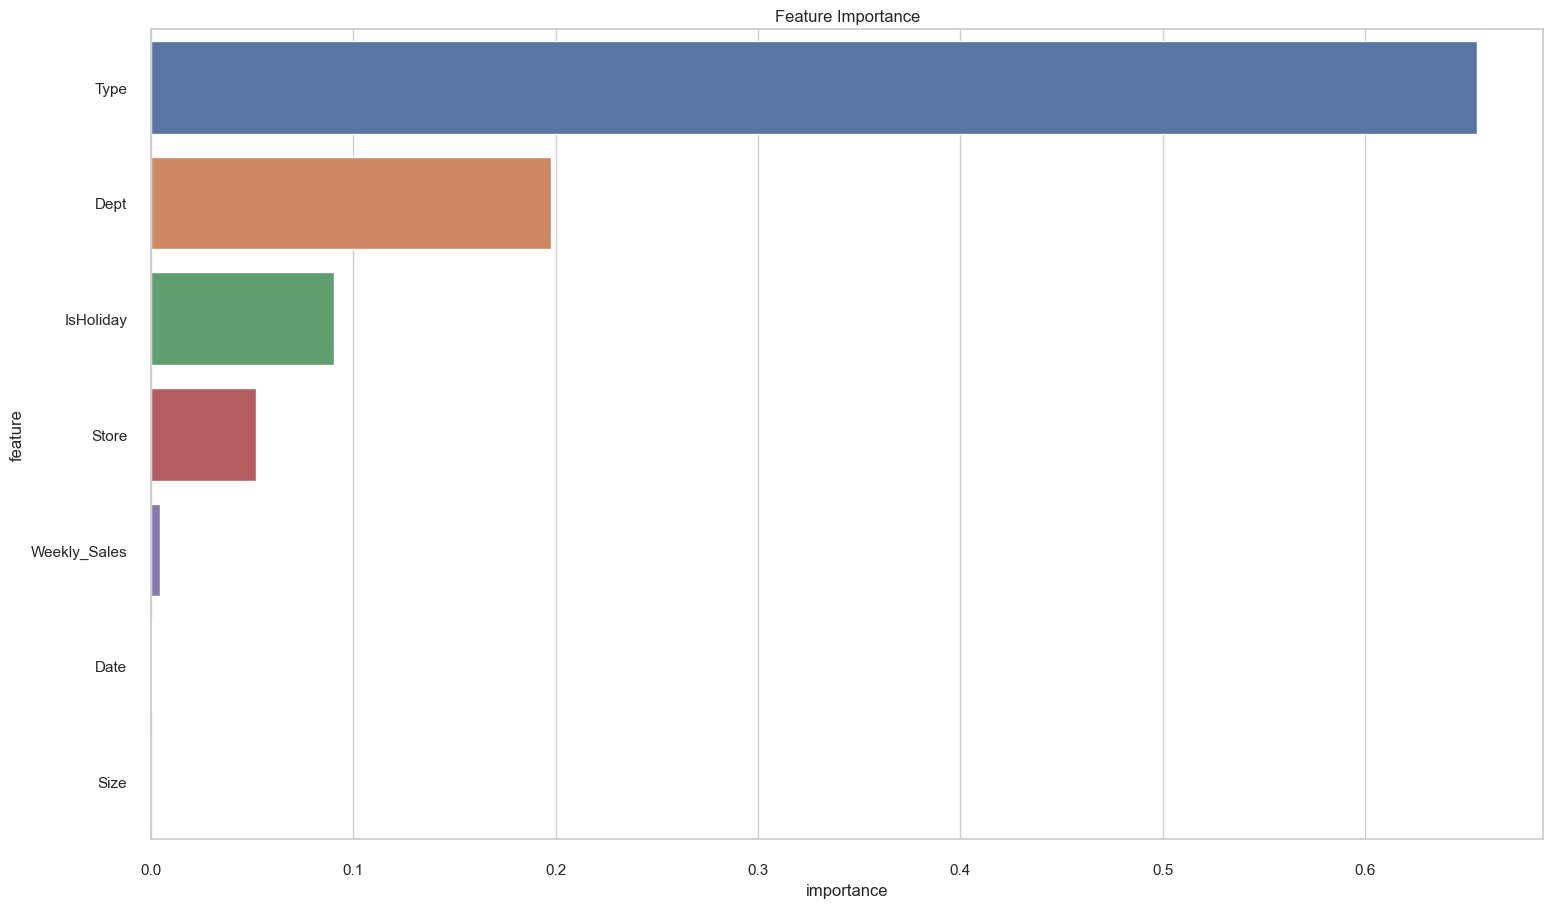

In [57]:
from pyspark.sql.types import StructType, StructField, StringType, DoubleType

# Assuming 'randomforest' is your trained Random Forest model
importance_data = [(feature, float(importance)) for feature, importance in zip(train_df2.columns, randomforest.featureImportances)]

# Define the schema with explicit data types
schema = StructType([
    StructField("feature", StringType(), True),
    StructField("importance", DoubleType(), True)
])

# Create the DataFrame with the defined schema
importance_df = spark.createDataFrame(importance_data, schema)

# Sort the DataFrame by importance in descending order
importance_df = importance_df.orderBy(col("importance").desc())

# Convert to Pandas DataFrame for local plotting
importance_pd = importance_df.toPandas()

# Create the feature importance plot
plt.figure(figsize=(16, 10))
plt.title('Feature Importance')
sns.barplot(data=importance_pd, x='importance', y='feature')
plt.show()


#### LinearRegression

In [58]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

# Create a LinearRegression model
lr = LinearRegression(featuresCol='features', labelCol= 'Weekly_Sales')

# Fit the model using a parameter map
param_map = {
    lr.regParam: 0.0,  # Regularization parameter
    lr.elasticNetParam: 0.0  # Elastic net parameter
}

model = lr.fit(train_df2, param_map)

# Make predictions on the training data
train_preds = model.transform(train_df2)

# Calculate evaluation metric (e.g., RMSE)
evaluator = RegressionEvaluator(labelCol='label', predictionCol='prediction', metricName='rmse')
train_rmse = train_evaluator.evaluate(train_preds)

print('WMSE on training data:', train_rmse)

# Make predictions on the validation data
val_preds = model.transform(val_df2)

# Calculate evaluation metric for validation data
val_rmse = train_evaluator.evaluate(val_preds)

print('WMSE on validation data:', val_rmse)


23/11/07 16:55:23 WARN Instrumentation: [1fbdff29] regParam is zero, which might cause numerical instability and overfitting.
23/11/07 16:55:23 WARN TaskSetManager: Stage 134 contains a task of very large size (3683 KiB). The maximum recommended task size is 1000 KiB.
23/11/07 16:55:23 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/11/07 16:55:24 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK
23/11/07 16:55:24 WARN TaskSetManager: Stage 136 contains a task of very large size (3683 KiB). The maximum recommended task size is 1000 KiB.
23/11/07 16:55:26 WARN TaskSetManager: Stage 138 contains a task of very large size (3683 KiB). The maximum recommended task size is 1000 KiB.
23/11/07 16:55:27 WARN TaskSetManager: Stage 140 contains a task of very large size (3683 KiB). The maximum recommended task size is 1000 KiB.


RMSE on training data: 14569.467490828793
RMSE on validation data: 14583.551300042831


#### DecisionTreeRegressor

In [59]:
from pyspark.sql import SparkSession
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.evaluation import RegressionEvaluator

# Create a SparkSession
spark = SparkSession.builder.appName("WalmartSalesForecast").getOrCreate()

# Define your train_df2 and val_df2 DataFrames

# Create a DecisionTreeRegressor
dt = DecisionTreeRegressor(featuresCol="features", labelCol="Weekly_Sales")

# Fit the model with the train_df2 DataFrame
decision_tree = dt.fit(train_df2)

# Make predictions on the training set
train_preds = decision_tree.transform(train_df2)

# Calculate WMAE for the training set
train_evaluator = RegressionEvaluator(labelCol="Weekly_Sales", metricName="mae")
train_wmae = train_evaluator.evaluate(train_preds)
print('The WMAE loss for the training set is {}.'.format(train_wmae))

# Make predictions on the validation set
val_preds = decision_tree.transform(val_df2)

# Calculate WMAE for the validation set
val_wmae = train_evaluator.evaluate(val_preds)
print('The WMAE loss for the validation set is {}.'.format(val_wmae))








23/11/07 16:55:28 WARN TaskSetManager: Stage 142 contains a task of very large size (3683 KiB). The maximum recommended task size is 1000 KiB.
23/11/07 16:55:28 WARN TaskSetManager: Stage 143 contains a task of very large size (3683 KiB). The maximum recommended task size is 1000 KiB.
23/11/07 16:55:29 WARN TaskSetManager: Stage 144 contains a task of very large size (3683 KiB). The maximum recommended task size is 1000 KiB.
23/11/07 16:55:30 WARN TaskSetManager: Stage 146 contains a task of very large size (3683 KiB). The maximum recommended task size is 1000 KiB.
23/11/07 16:55:31 WARN TaskSetManager: Stage 148 contains a task of very large size (3683 KiB). The maximum recommended task size is 1000 KiB.
23/11/07 16:55:31 WARN TaskSetManager: Stage 150 contains a task of very large size (3683 KiB). The maximum recommended task size is 1000 KiB.
23/11/07 16:55:31 WARN TaskSetManager: Stage 152 contains a task of very large size (3683 KiB). The maximum recommended task size is 1000 KiB.

The WMAE loss for the training set is 9468.314207525373.
The WMAE loss for the validation set is 9183.5112872512.


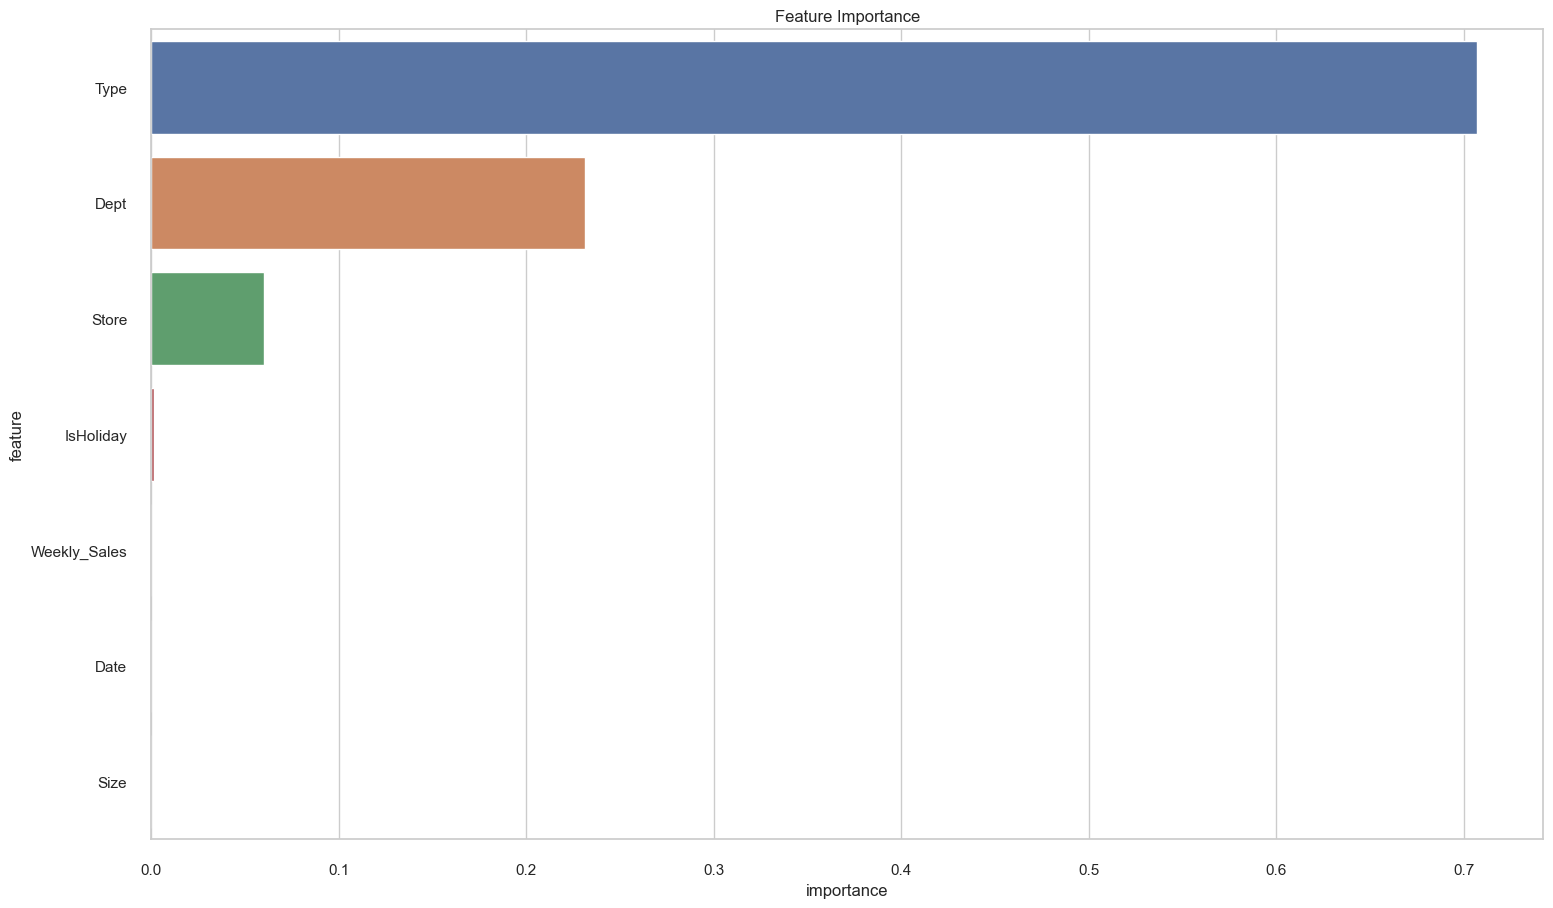

In [60]:
# Assuming 'randomforest' is your trained Random Forest model
importance_data = [(feature, float(importance)) for feature, importance in zip(train_df2.columns, decision_tree.featureImportances)]

# Define the schema with explicit data types
schema = StructType([
    StructField("feature", StringType(), True),
    StructField("importance", DoubleType(), True)
])

# Create the DataFrame with the defined schema
importance_df = spark.createDataFrame(importance_data, schema)

# Sort the DataFrame by importance in descending order
importance_df = importance_df.orderBy(col("importance").desc())

# Convert to Pandas DataFrame for local plotting
importance_pd = importance_df.toPandas()

# Create the feature importance plot
plt.figure(figsize=(16, 10))
plt.title('Feature Importance')
sns.barplot(data=importance_pd, x='importance', y='feature')
plt.show()

# summary
**1.Sales heavlly depend on Type and Deptartment** \
**2.Size of store also play major role in sales big store usually have more weekly_sales**\
**3.A type store did more sales than b and c**\
**4.weekly sales also depend on week of the year holidays weeks are good for sales**\